In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.2 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.3 pynndescent==0.5.8


specify the read and write locations

In [3]:
DIR = "/mnt/nas/wgs/geneseeq/scRNA/ref_normal"
results_file = DIR + "/results.h5ad"


Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [4]:
adata = sc.read_10x_mtx(
    DIR,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/mnt-nas-wgs-geneseeq-scRNA-ref_normal-matrix.h5ad


See [anndata-tutorials/getting-started](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) for a more comprehensive introduction to `AnnData`.

In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Quality control

check the percentage of doublets in the data

In [ ]:
# sc.external.pp.scrublet(adata, n_neighbors=30, expected_doublet_rate=0.06)


Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


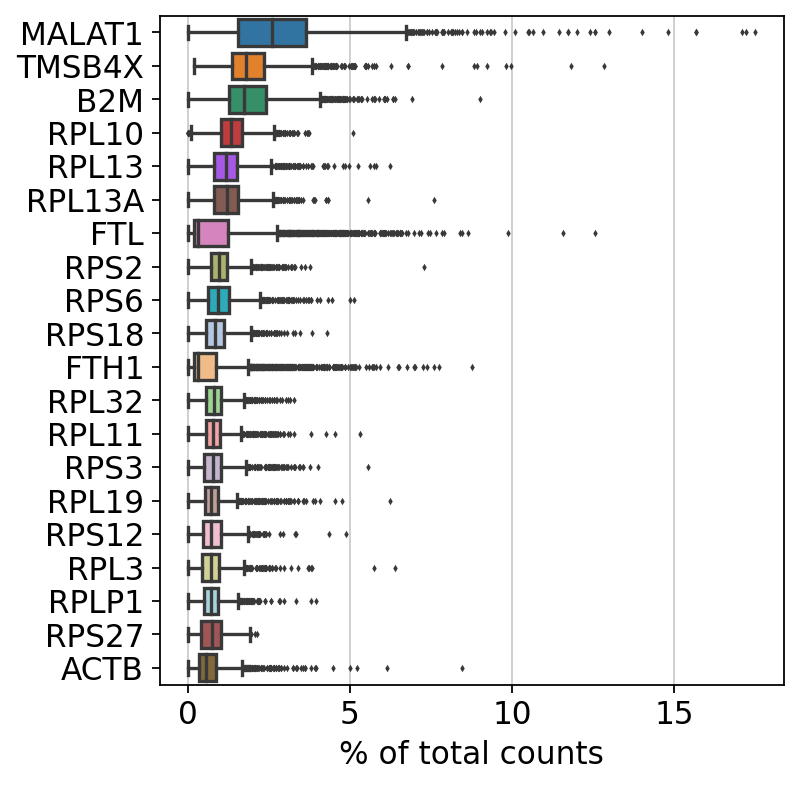

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

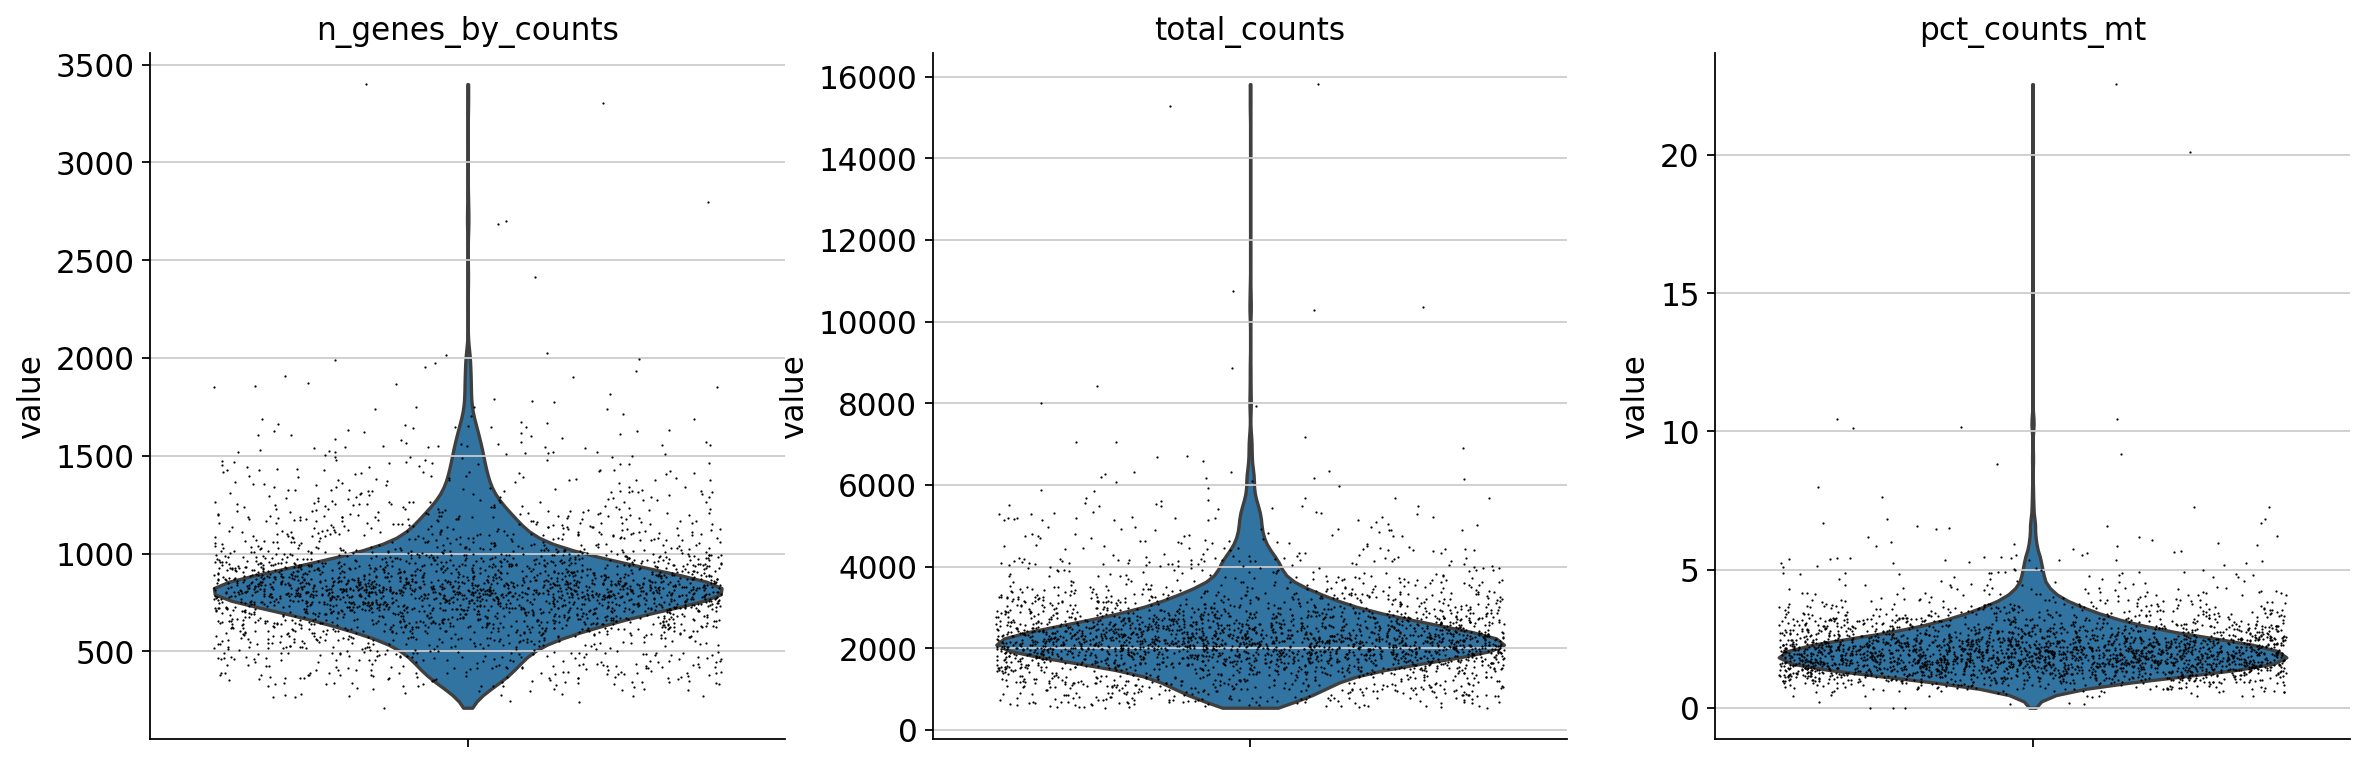

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

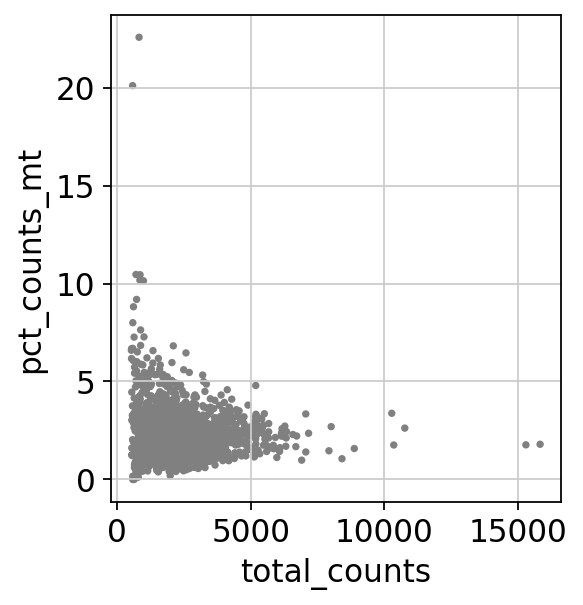

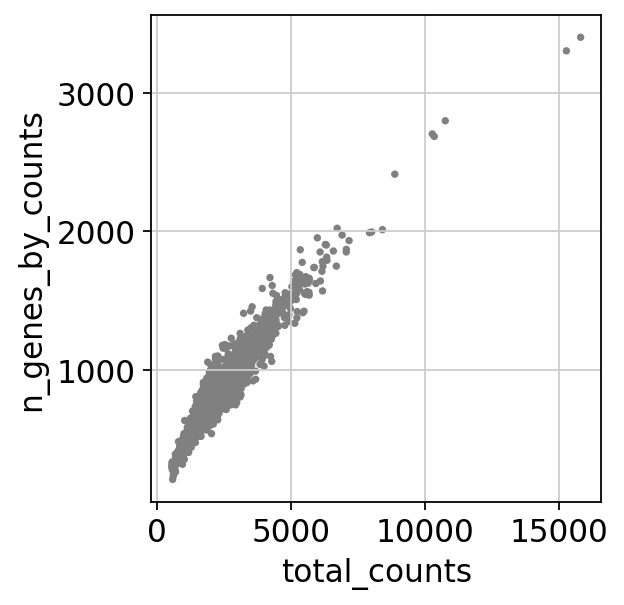

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Actually do the filtering by slicing the `AnnData` object.

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

## Normalisation

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/ma/miniconda3/envs/torch/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize the data:

In [15]:
sc.pp.log1p(adata)

## Feature selection

Identify highly-variable genes.

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


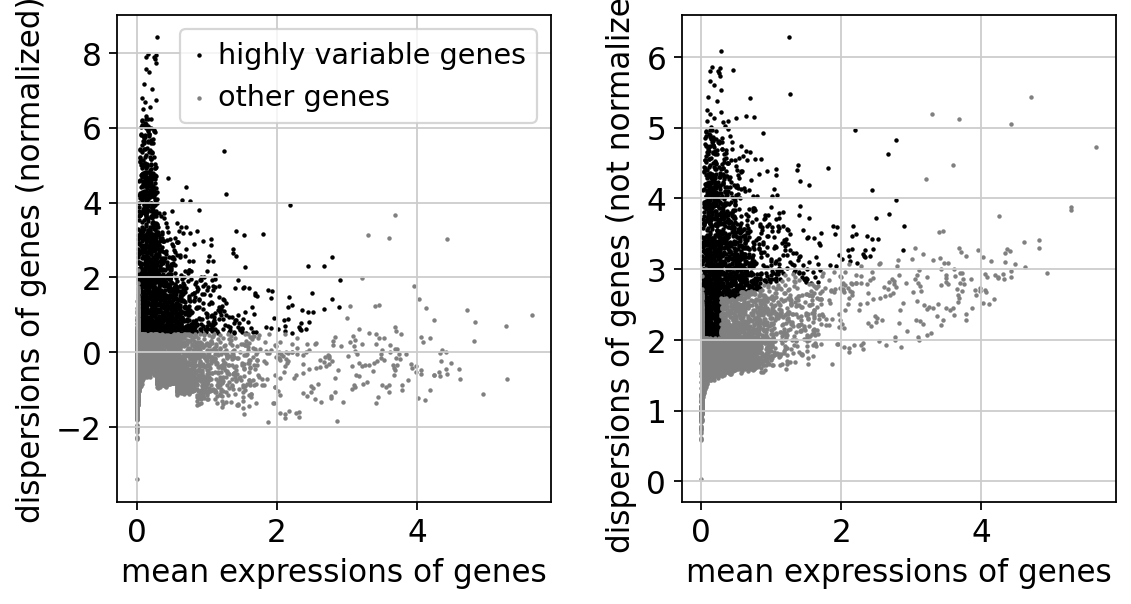

In [17]:
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

<div class="alert alert-info">

**Note**

You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.

</div>    

In [18]:
adata.raw = adata

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

Actually do the filtering

In [19]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [20]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [21]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

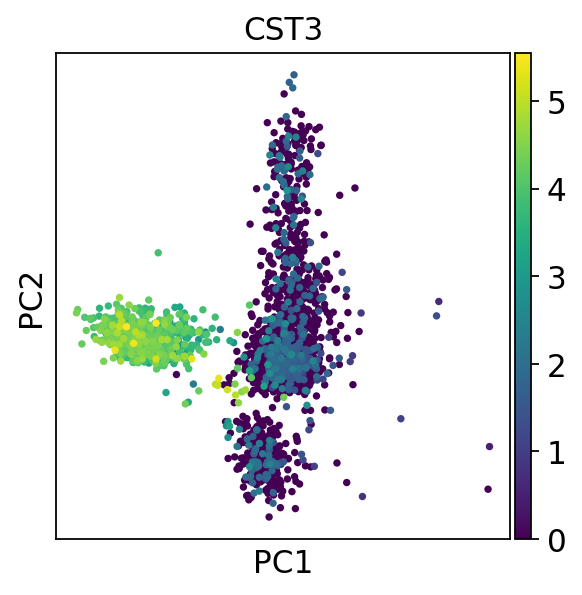

In [23]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

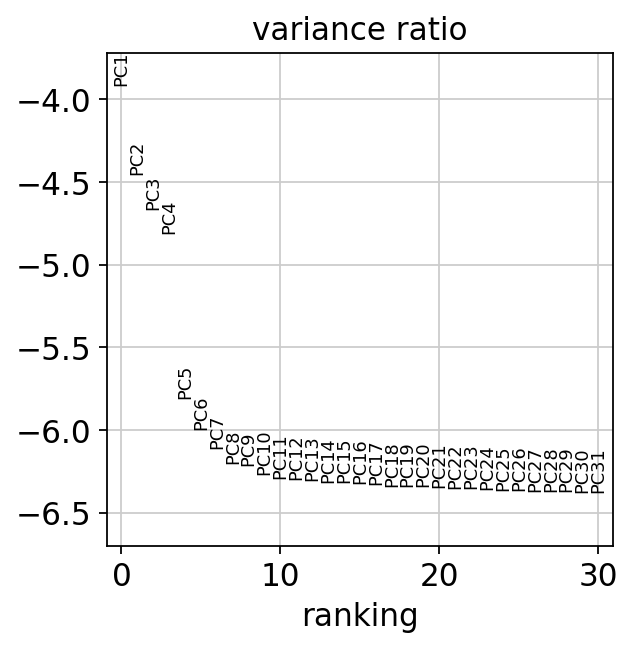

In [24]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [25]:
adata.write(results_file)

In [26]:
adata

AnnData object with n_obs × n_vars = 2694 × 1860
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [27]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [28]:
# show the neighborhood metrics
adata.uns['neighbors']

OverloadedDict, wrapping:
	{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'n_neighbors': 15, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean', 'n_pcs': 40}}
With overloaded keys:
	['connectivities', 'distances'].

## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```Python
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
```

In [29]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


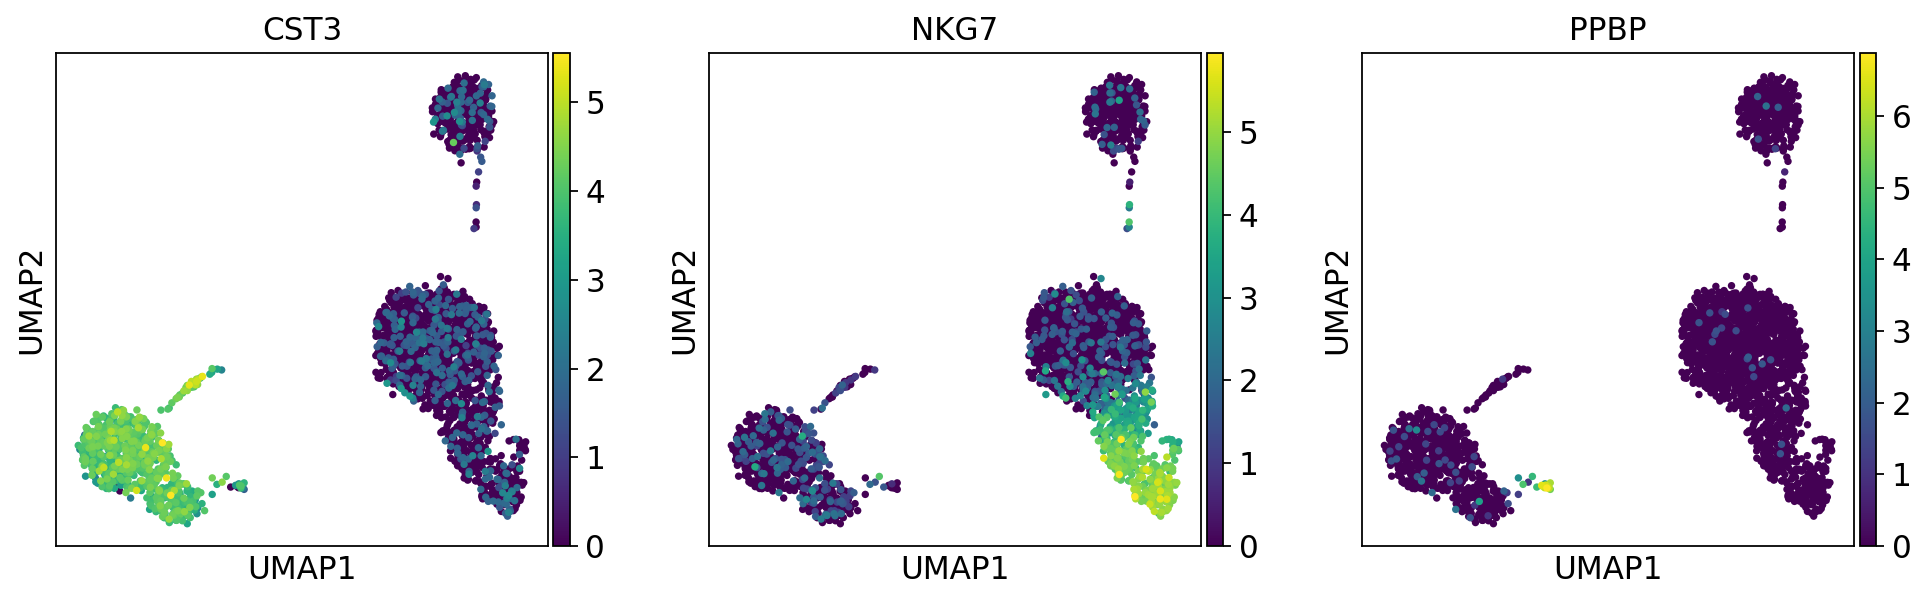

In [30]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

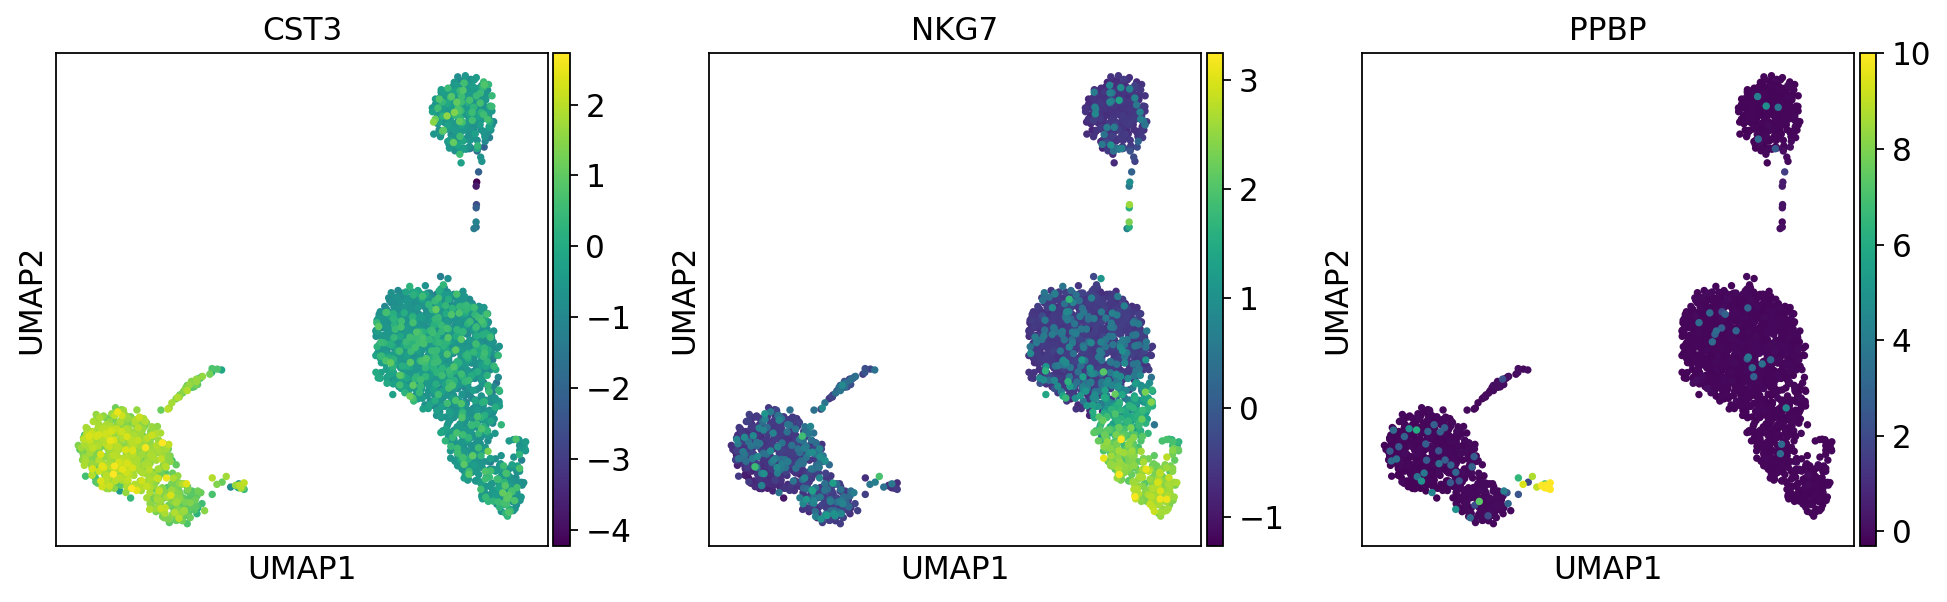

In [31]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [32]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

/home/ma/miniconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


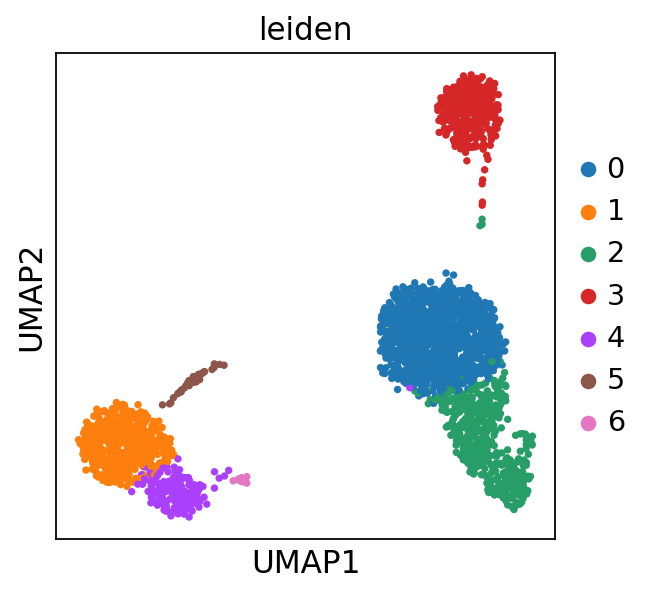

In [33]:
sc.pl.umap(adata, color='leiden')

Save the result.

In [34]:
adata.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


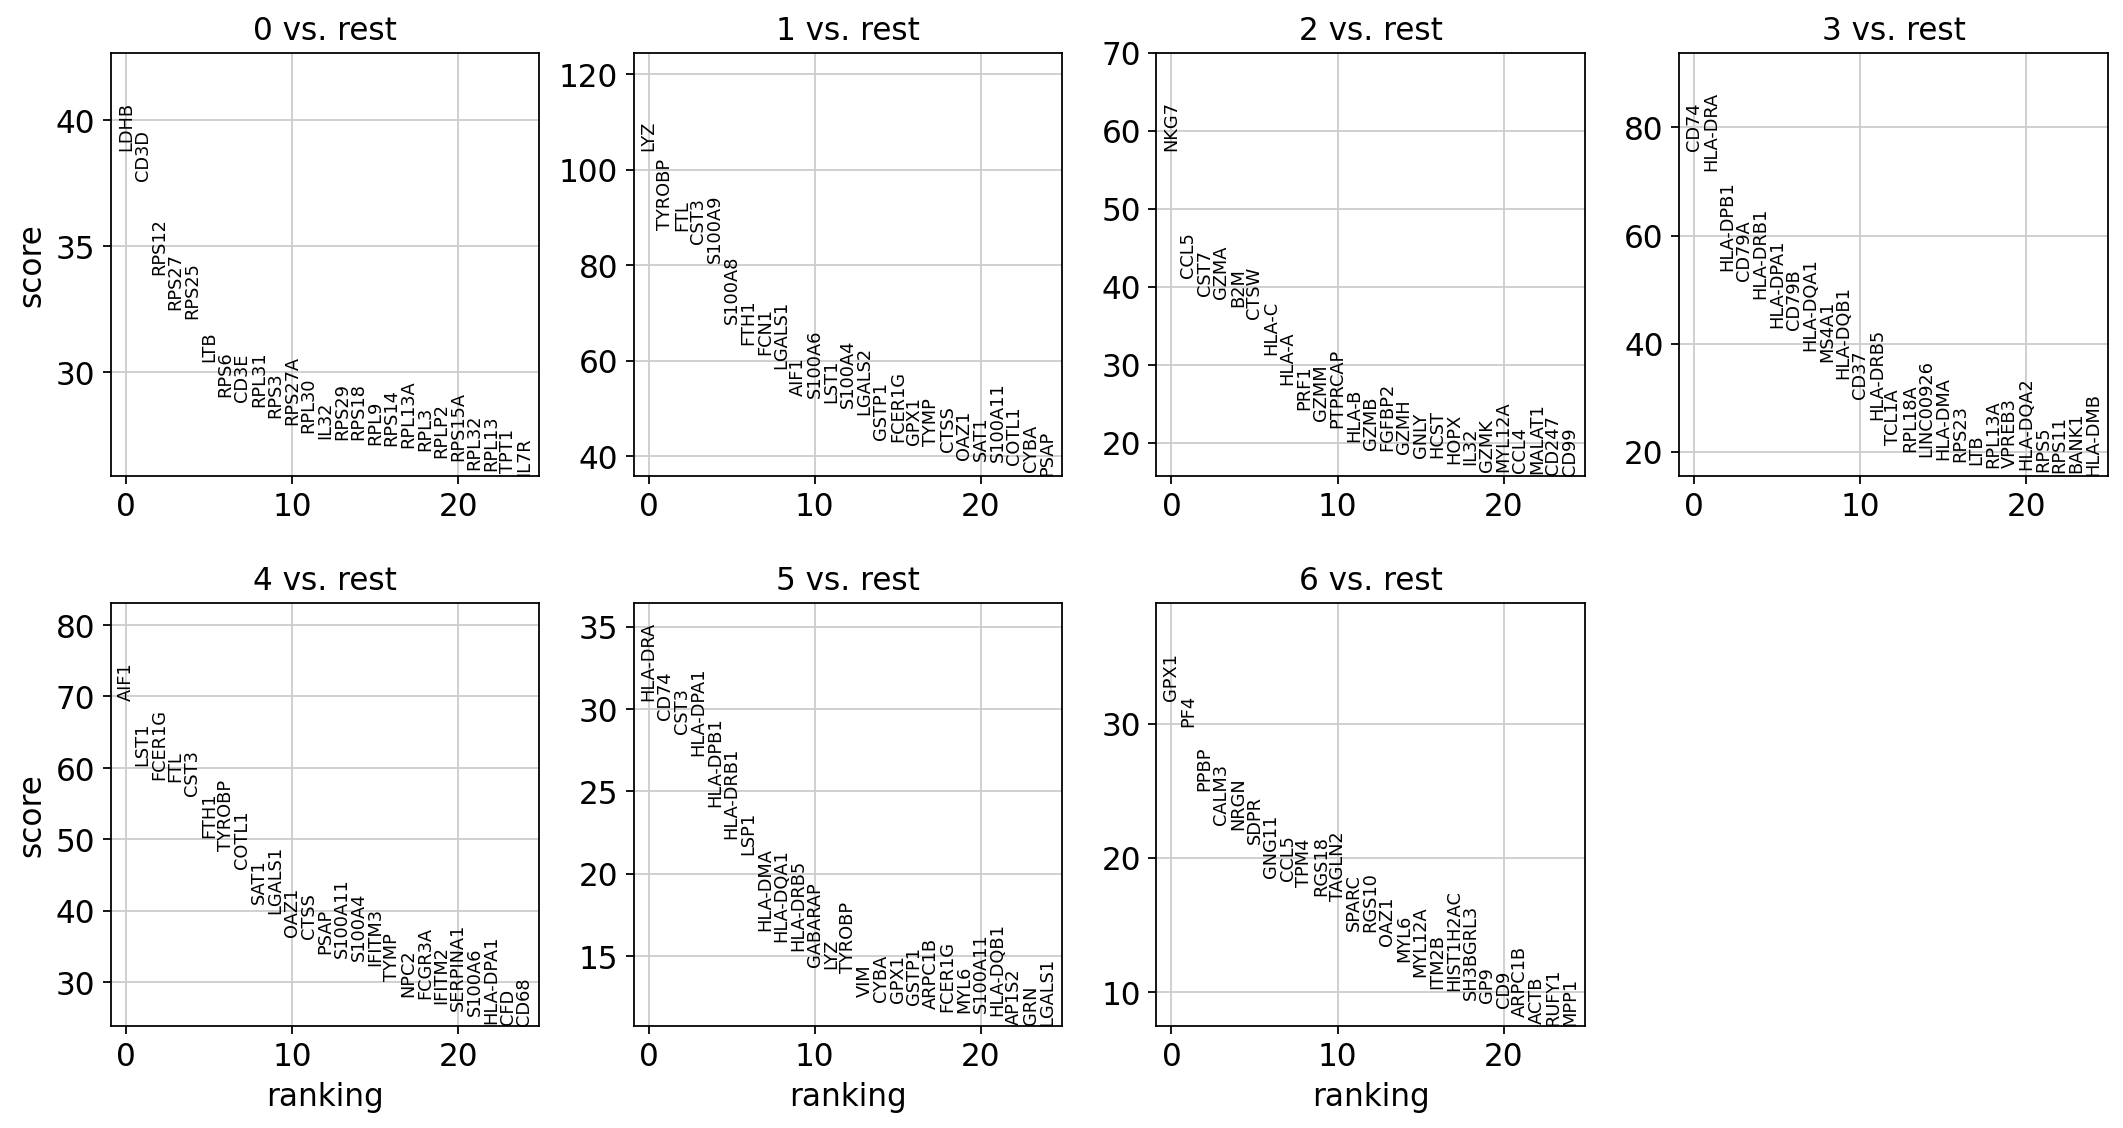

In [35]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [36]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:02)


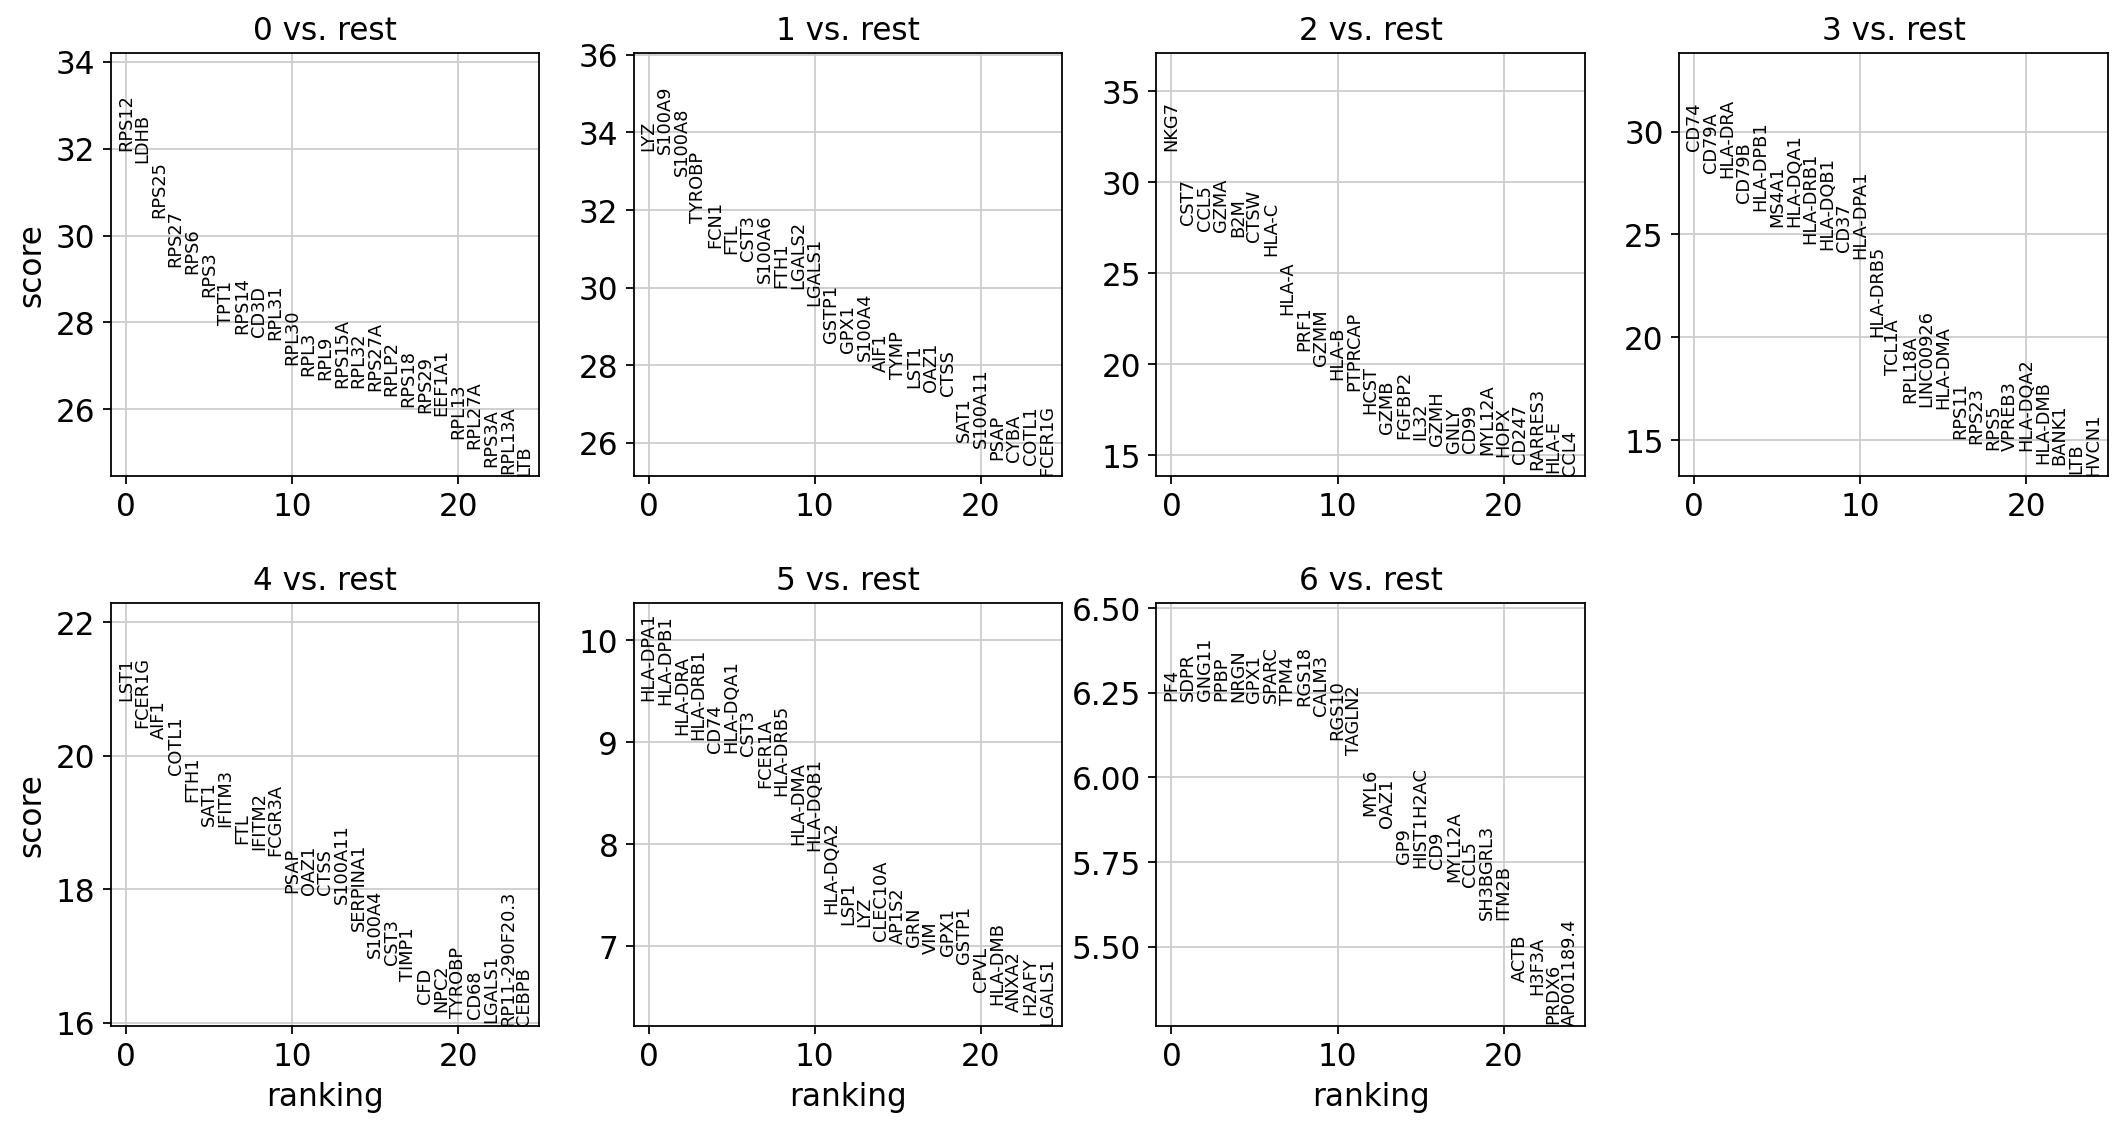

In [37]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [38]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:05)


/home/ma/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


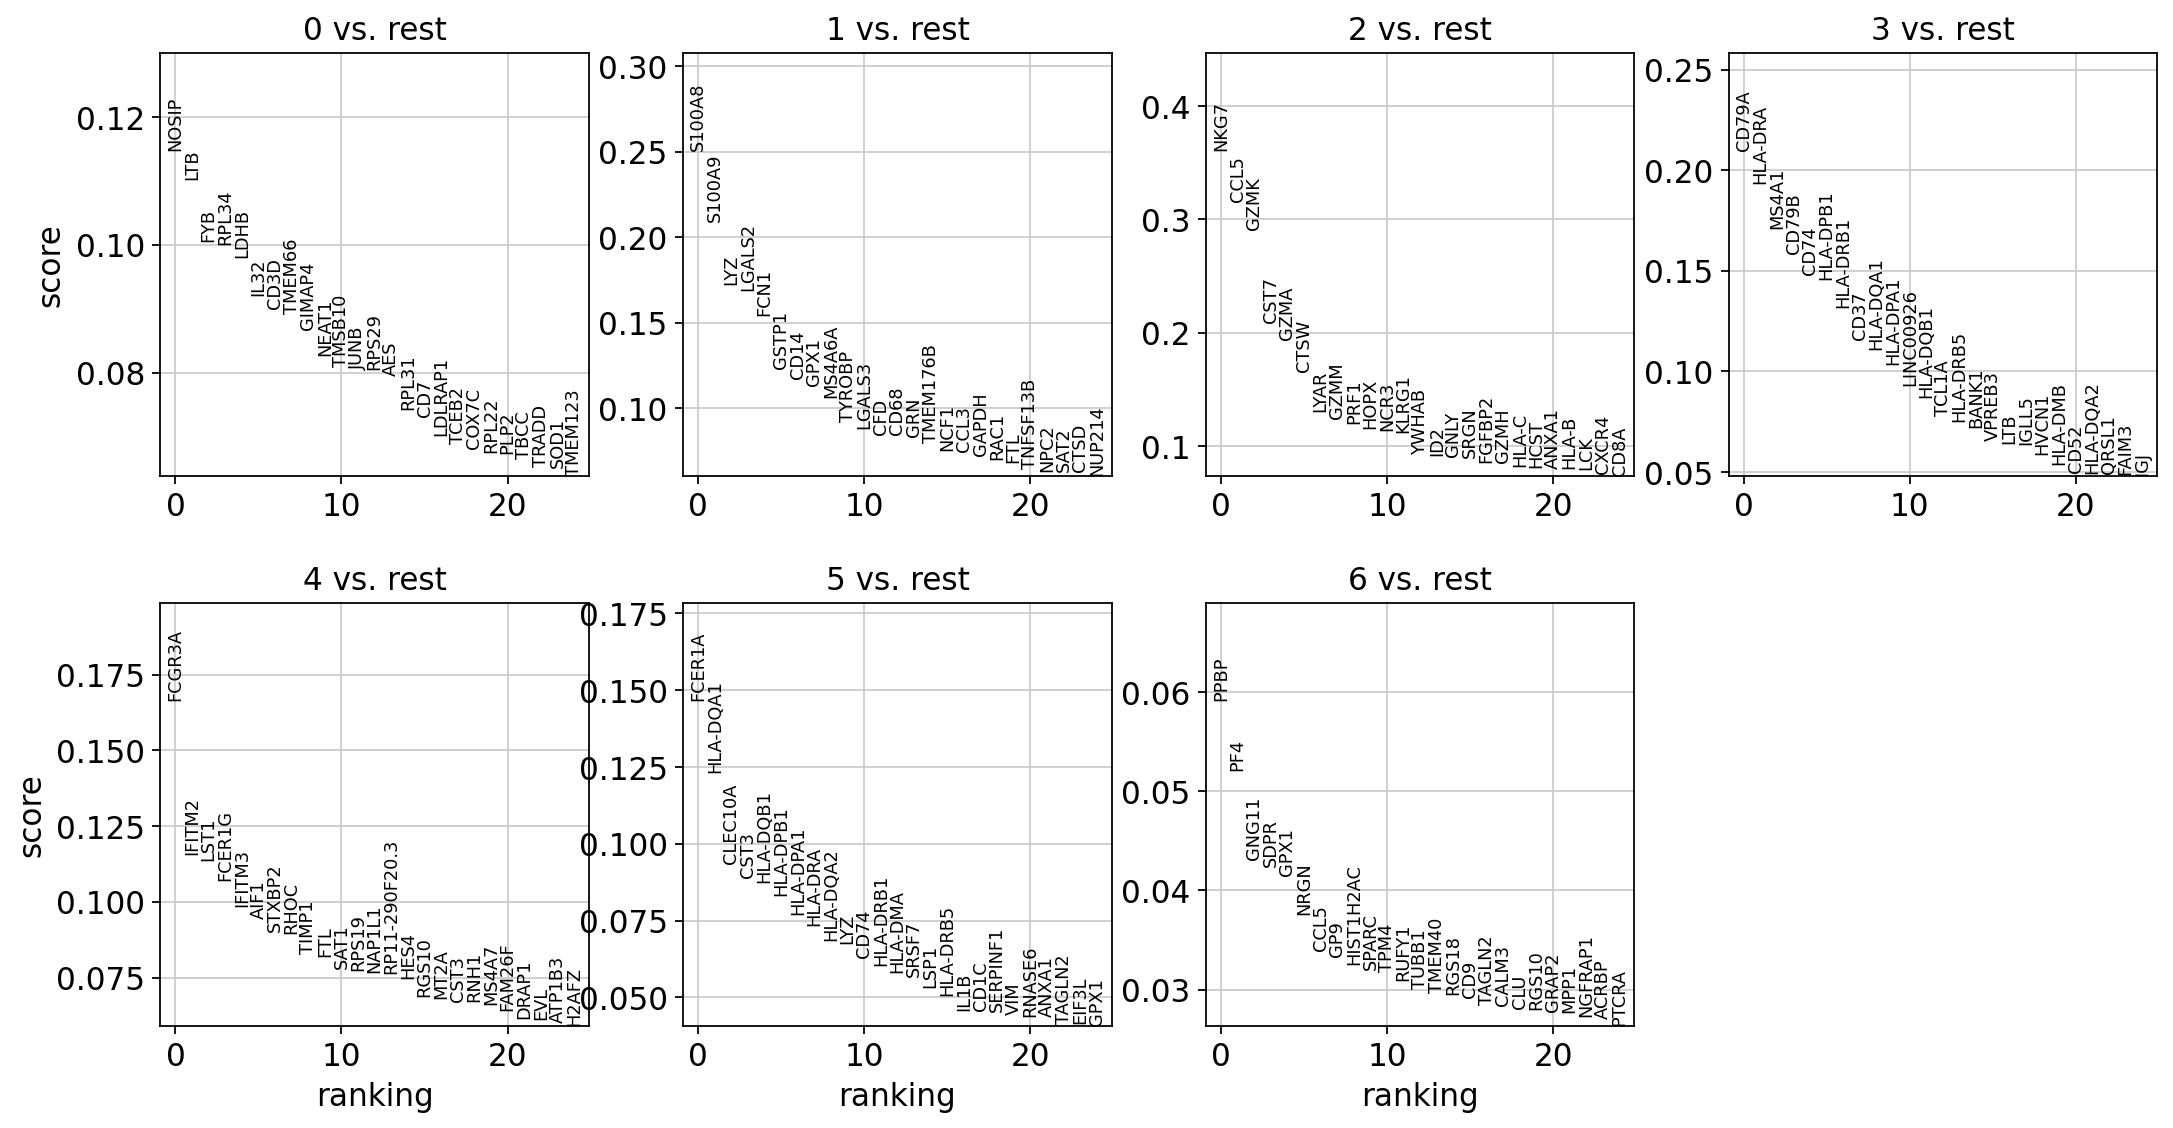

In [39]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Let us also define a list of marker genes for later reference.

In [40]:
# 'IGHG1' is not present
select_markers = {'CCR7', 'CD14', 'CD1C', 'CD4', 'CD68', 'CD79A', 'CD8A', 'CD8B', 'CST3',
    'FCER1A', 'FCGR3A', 'GNLY', 'GZMA', 'IL7R', 'KLRB1', 'KLRF1', 'LGALS3', 'LYZ',
    'MKI67', 'MS4A1', 'MS4A7', 'MZB1', 'NKG7', 'PPBP', 'S100A8', 'SLC4A10'}

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [41]:
adata = sc.read(results_file)
adata.uns['log1p']["base"] = None
adata

AnnData object with n_obs × n_vars = 2694 × 1860
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Show the 5 top ranked genes per cluster

In [42]:
expressed = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
expressed

,0,1,2,3,4,5,6
0,RPS12,LYZ,NKG7,CD74,LST1,HLA-DPA1,PF4
1,LDHB,S100A9,CST7,CD79A,FCER1G,HLA-DPB1,SDPR
2,RPS25,S100A8,CCL5,HLA-DRA,AIF1,HLA-DRA,GNG11
3,RPS27,TYROBP,GZMA,CD79B,COTL1,HLA-DRB1,PPBP
4,RPS6,FCN1,B2M,HLA-DPB1,FTH1,CD74,NRGN


In [43]:
# turn the dataframe into a set
all_markers = set(expressed.values.flatten())
len(all_markers)

32

In [44]:
# get the intersection between all_markers and selec_markers
all_markers & select_markers

{'CD79A', 'GZMA', 'LYZ', 'NKG7', 'PPBP', 'S100A8'}

In [45]:
expressed.to_csv('ZX.csv')

Compare to a single cluster: 

ranking genes
    finished (0:00:01)


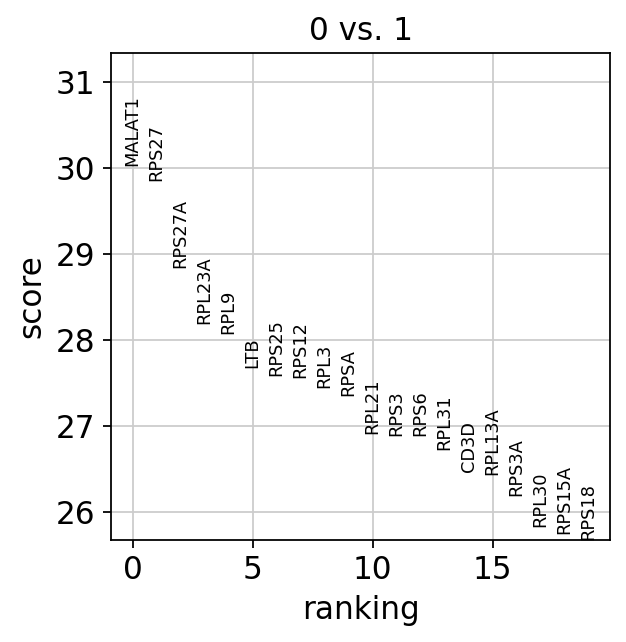

In [46]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

/home/ma/miniconda3/envs/torch/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


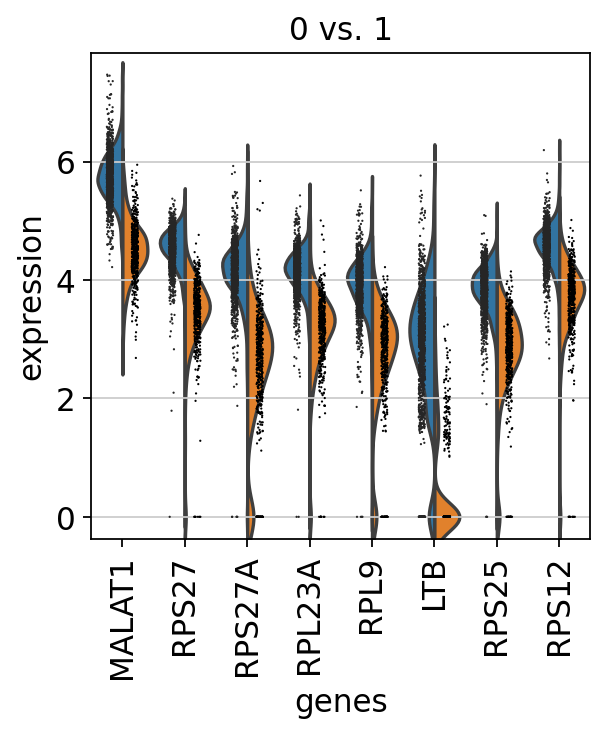

In [47]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [48]:
adata = sc.read(results_file)

/home/ma/miniconda3/envs/torch/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


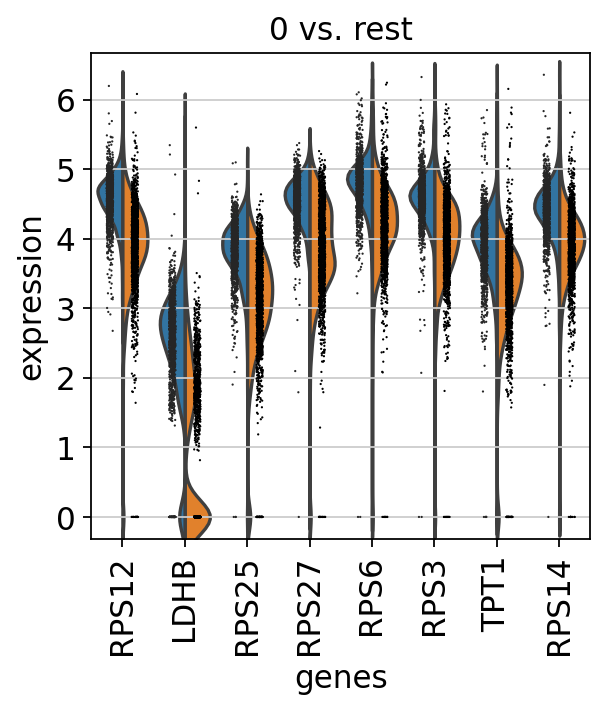

In [49]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

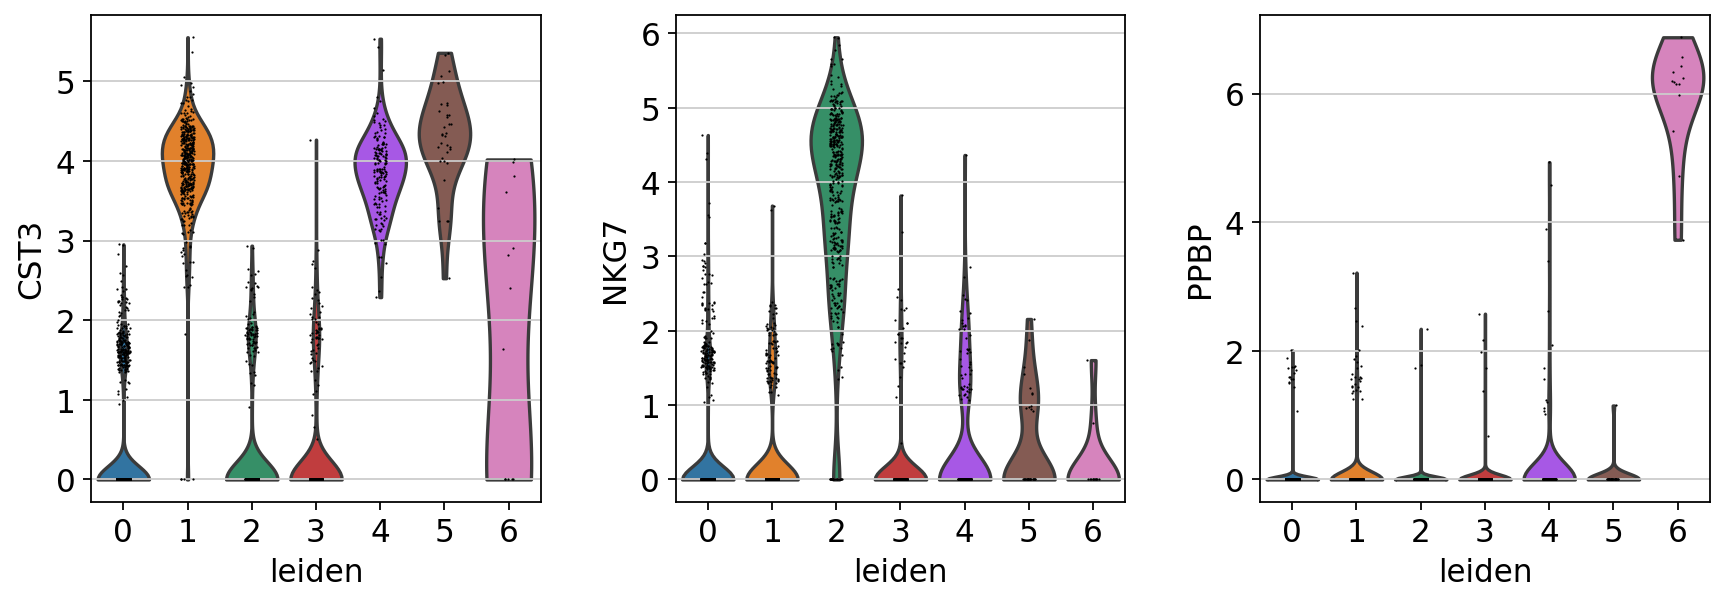

In [50]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Actually mark the cell types.

/home/ma/miniconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


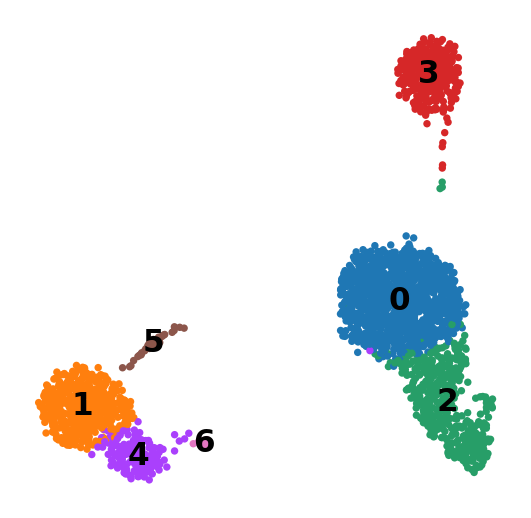

In [51]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

let us visualize the marker genes.

/home/ma/miniconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


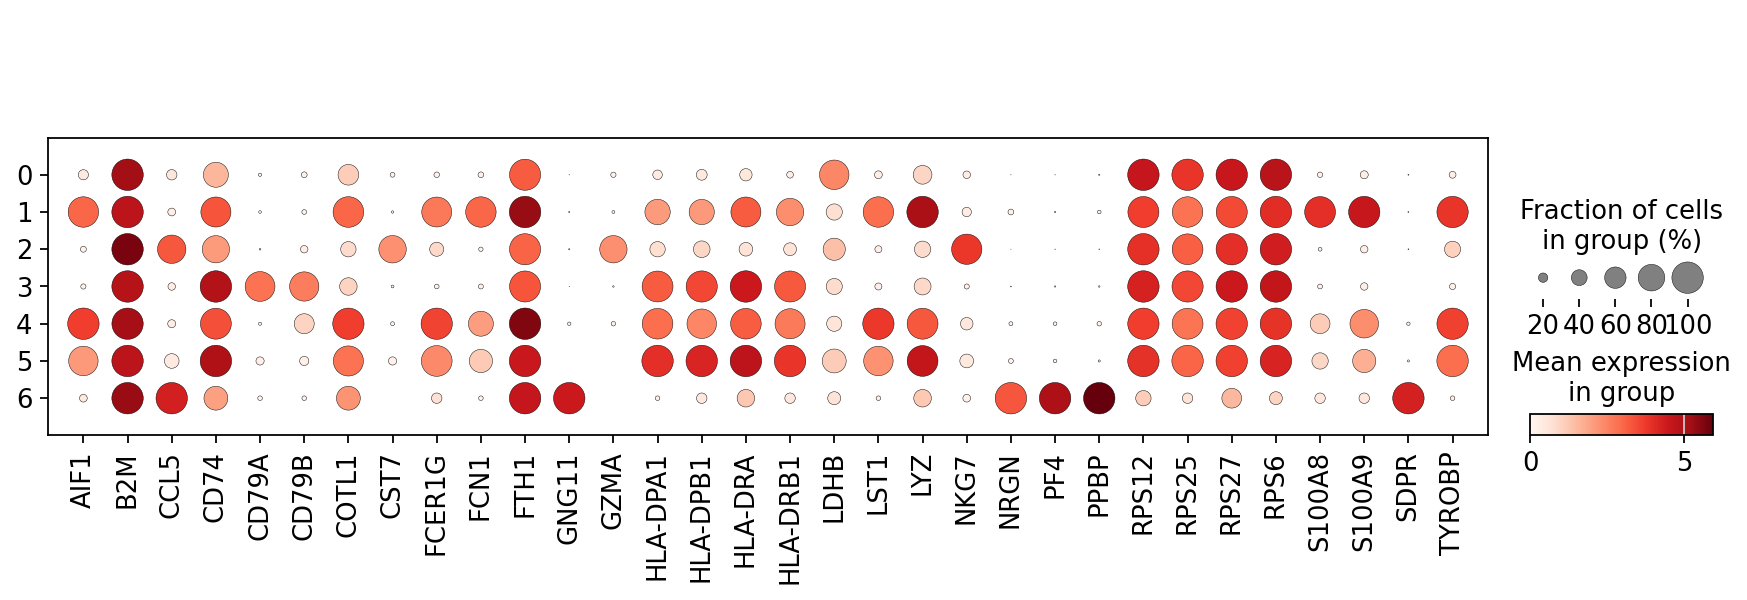

In [52]:
sc.pl.dotplot(adata, sorted(list(all_markers)), groupby='leiden');

/home/ma/miniconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


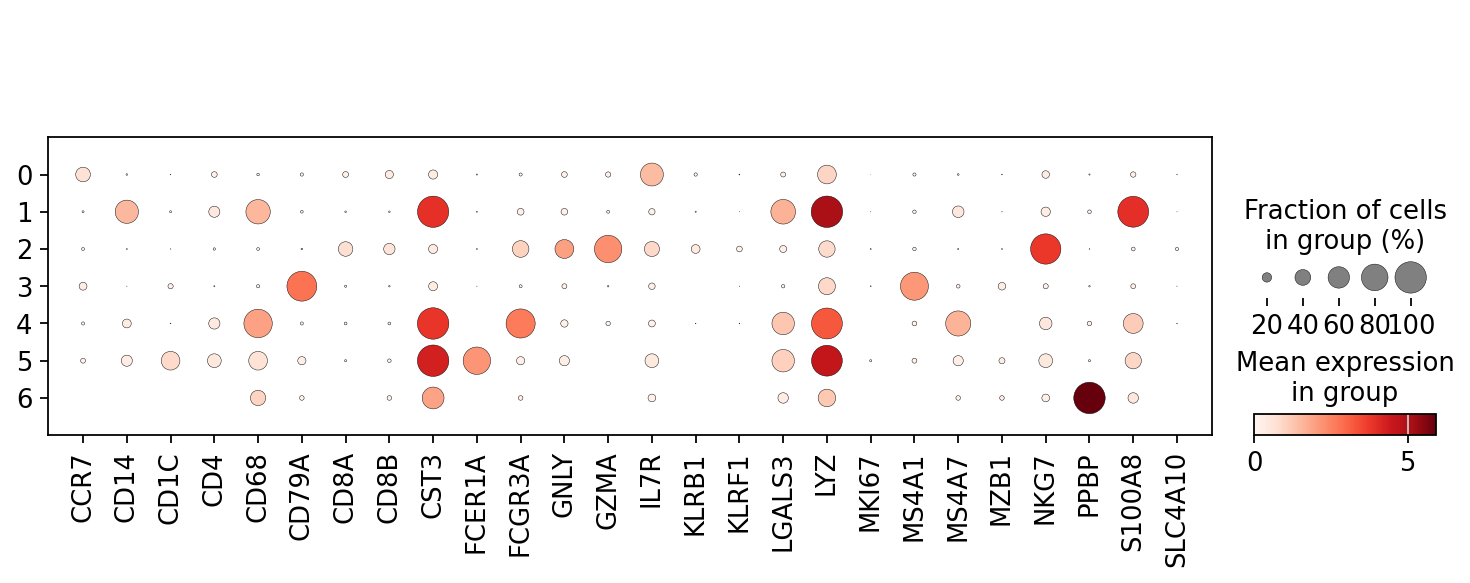

In [53]:
sc.pl.dotplot(adata, sorted(list(select_markers)), groupby='leiden');

There is also a very compact violin plot.

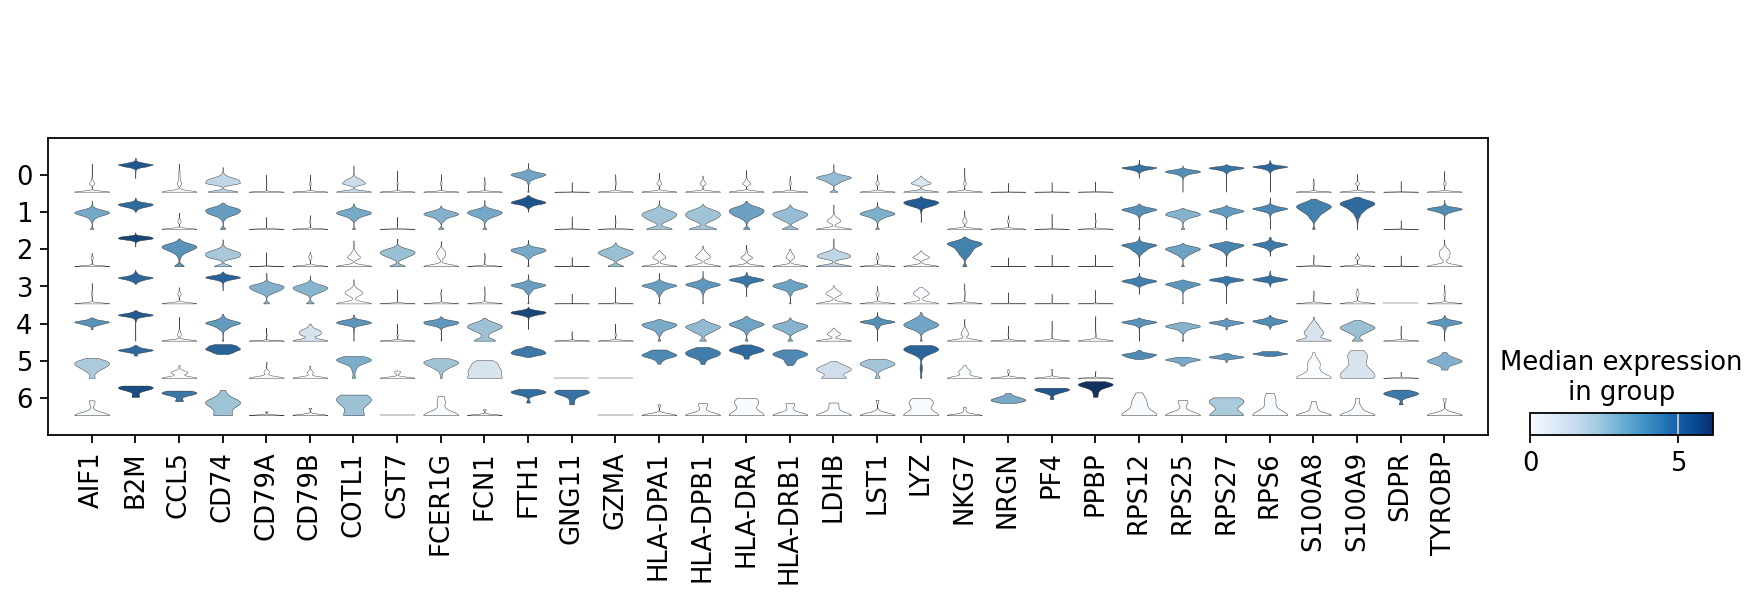

In [54]:
sc.pl.stacked_violin(adata, sorted(list(all_markers)), groupby='leiden', rotation=90);

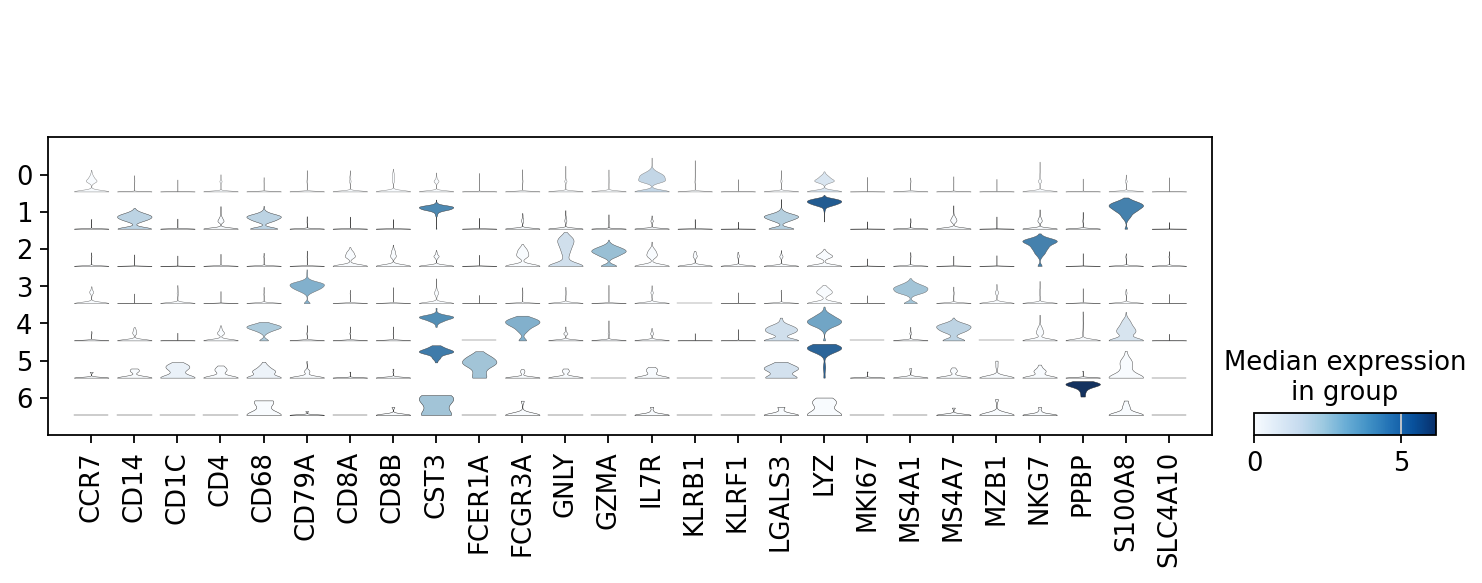

In [55]:
sc.pl.stacked_violin(adata, sorted(list(select_markers)), groupby='leiden', rotation=90);

During the course of this analysis, the AnnData accumlated the following annotations.

In [56]:
adata

AnnData object with n_obs × n_vars = 2694 × 1860
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'